# Localized Spectral Analysis on the Sphere

A localised spectral estimate can be seen as the spectrum of a global function multiplied with a window. In a 2D cartesian coordinate system, this multiplication becomes a convolution in Fourier domain: the window *couples* different Fourier coefficients of the global function to each other.

Windowing on the sphere leads to similar effects: Multiplication with a window function leads to coupling of the spherical harmonic coefficients of the globally defined function. In the case of an isotropic and stationary function, a coupling matrix describes the relation between the input power to the output power. This matrix resembles a convolution at high degrees.

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np

## Generate a random model using the SHCoeffs class interface

We first generate a random model using the SHCoeffs class interface to SHTOOLS. This class simplifies coefficient generation and provides a simple access to most SHTOOLS functions. We start by generating coefficients that have a power spectrum that follows a power-law decay.

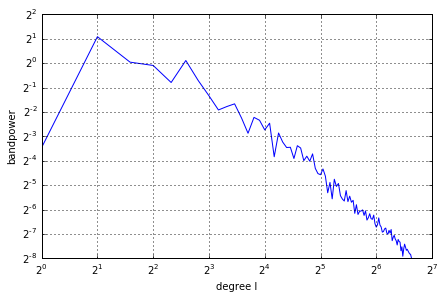

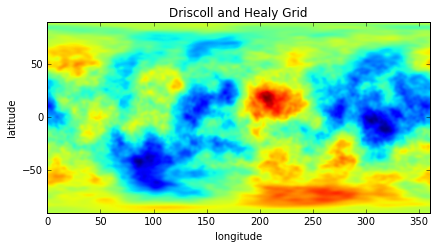

(<matplotlib.figure.Figure at 0x11512c438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115032710>)

In [2]:
from pyshtools.shclasses import SHCoeffs, SHWindow, SHGrid

nl = 100  # l = [0, 199]
lmax = nl - 1
a = 4  # scale length
ls = np.arange(nl, dtype=np.float)
power = 1. / (1. + (ls / a) ** 2) ** 1.5

# Generate the random coefficients using an input power spectrum.
coeffs_global = SHCoeffs.from_random(power)

# Plot the power per log bandwidth spectrum using the class method spectrum().
coeffs_global.plot_spectrum(unit='per_dlogl')

# Get the power per degree spectrum as a numpy array using the class method
# spectrum().
power_global = coeffs_global.spectrum()

# Expand the data on a global grid using the class method expand().
grid_global = coeffs_global.expand('DH2')

# Plot the raw grid using the class method plot().
grid_global.plot()

## Generate a box window function

We now generate a window function that picks a few local regions from the globally defined model. In this example, the window contains sharp boundaries, so the spherical harmonic bandwidth of the function is infinite. In general, this could severely bias the localized power spectrum away from its global value, especially when the power spectrum follows a power law. To combat this negative characteristic, we will later show how to construct windows with a specified spherical harmonic bandwith that are optimally concentrated within the provided region.

The example makes use of the SHTOOLS class SHGrid, which is the counterpart to SHCoeffs.

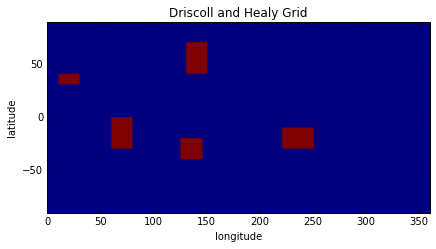

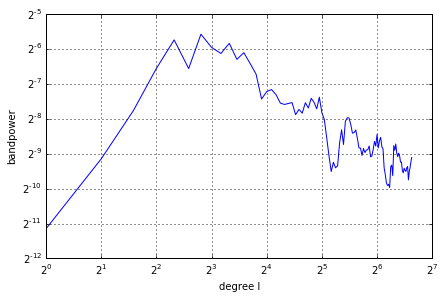

In [3]:
# Make an arbitrary mask.
latgrid, longrid = np.meshgrid(grid_global.lats(), grid_global.lons(), indexing='ij')
window = (-40 < latgrid) & (latgrid < -30) & (10 < longrid) & (longrid < 30)
window += (0 < latgrid) & (latgrid < 30) & (60 < longrid) & (longrid < 80)
window += (-70 < latgrid) & (latgrid < -40) & (130 < longrid) & (longrid < 150)
window += (20 < latgrid) & (latgrid < 40) & (125 < longrid) & (longrid < 145)
window += (10 < latgrid) & (latgrid < 30) & (220 < longrid) & (longrid < 250)

# Generate an SHGrid instance from the input array. The first element of the grid corresponds
# to zero longitude and 90 degrees north.
grid_window = SHGrid.from_array(window.astype(np.float64)[::-1])  # DH grid starts at north-pole

grid_window.plot()

# Expand the grid in spherical harmonics using the class method expand().
coeffs_window = grid_window.expand()

coeffs_window.plot_spectrum(unit='per_dlogl')
power_window = coeffs_window.spectrum()
norm_window = power_window.sum()

## Multiply the random model with the window

Multiplication of the global random model with the window function localizes the data, and its expansion in spherical harmonics gives a *local* power spectrum estimate of the input function. The interaction of the window function with the random model *distorts* the spectrum. In general, the ouput spectrum at degree l is influenced by the input spherical harmonic degrees from l - Lwin to l + Lwin, where Lwin in the spherical harmonic bandwidth of the windowing function.

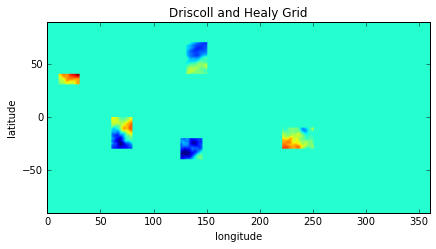

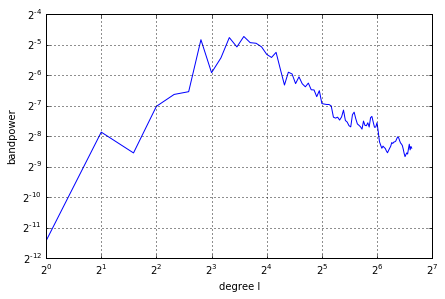

In [4]:
# Multiply the data by the window and plot the spatially localized data.
grid_local = SHGrid.from_array(grid_global.data * grid_window.data)
grid_local.plot()

# Next, expand the localized data in spherical harmonics and plot the
# power per band spectrum.
coeffs_local = grid_local.expand()
coeffs_local.plot_spectrum(unit='per_dlogl')
power_local = coeffs_local.spectrum()

## Compute the coupling matrix

The expected distortion of the global spectrum due to the windowing operation can be described by a *coupling matrix* under the assumption that the model is isotropic and stationary. This means that the local (expected) spectra are independent of the position and orientation of the windows. In this case, the expected local spectrum depends only on the power spectrum of the window, which is taken as input for the SHMTCouplingMatrix function.

The coupling matrix describes how input power maps to output power. At high degrees, it is approximately symmetric around the diagonal and resembles a convolution in degree l space. At low degrees, however, input power is spread more unevently into output power. For example, input degree 0 maps preferentially to output degree 4, which is off-diagonal. This is a direct consquence of describing a 2D multiplication with coupling of a single dimension parameter *l*. A similar bias can be seen when describing coupling in 2D Fourier space between coefficients with similar |k|.

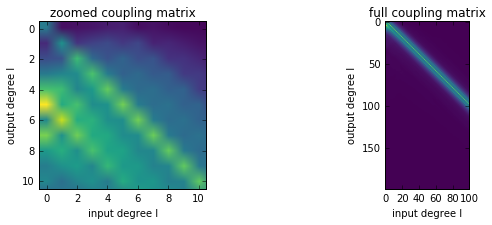

In [5]:
# Compute the coupling matrix
from pyshtools.localizedspectralanalysis import SHMTCouplingMatrix
coupling_matrix = SHMTCouplingMatrix(lmax, power_window.reshape(nl, 1))

# Plot the coupling matrix
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 3))
col1.imshow(coupling_matrix, cmap='viridis')
col1.set(xlabel='input degree l', ylabel='output degree l', xlim=(-0.5, 10.5), ylim=(10.5, -0.5),
         title='zoomed coupling matrix');
col2.imshow(coupling_matrix, cmap='viridis')
col2.set(xlabel='input degree l', ylabel='output degree l', title='full coupling matrix');

## Predict the biased spectrum

Finally, the coupling matrix can be used to predict the spectrum of the windowed function. SHTOOLS provides also the functions SHBiasK and SHBias that can compute directly the biased spectrum without explicitely computing the coupling matrix. Under some assumptions, the coupling matrix can be inverted allowing the global input power spectrum to be estimated from the localized spectrum. This has to be done with care because as a smoothing operation, windowing leads to loss of information (less resolution in degree l space) and has to be regularized to stabilize the inversion.

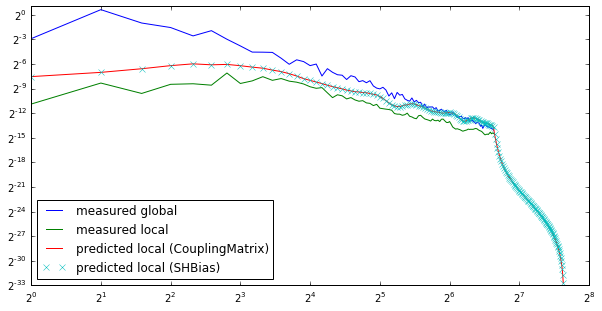

In [6]:
# Compute the biased spectrum using two different methods
from pyshtools.localizedspectralanalysis import SHBias
power_local2 = np.dot(coupling_matrix, power)
power_local3 = SHBias(power_window, power)

# plot the observed and predicted spectra
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ls, power_global, label='measured global')
ax.plot(ls, power_local, label='measured local')
ax.plot(power_local2, label='predicted local (CouplingMatrix)')
ax.plot(power_local3, 'x', label='predicted local (SHBias)')
ax.legend(loc=3)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)